In [1]:
import numpy as np
from numba import njit

# ----------------------------------
# MK b=2, d=2: R logs and RG step
# ----------------------------------

@njit(cache=True)
def log_Rpp_Rpm_nn_mk_b2_d2(J):
    J_bm = 2.0 * J  # bond moving: b^(d-1)
    log_R_pp = np.log(2.0 * np.cosh(2.0 * J_bm))  # = log[2 cosh(4J)]
    log_R_pm = np.log(2.0)
    return log_R_pp, log_R_pm


@njit(cache=True)
def rg_step_J_nn_mk_b2_d2(J):
    log_R_pp, log_R_pm = log_Rpp_Rpm_nn_mk_b2_d2(J)
    return 0.5 * (log_R_pp - log_R_pm)


@njit(cache=True)
def G_tilde_nn_mk_b2_d2(J):
    log_R_pp, log_R_pm = log_Rpp_Rpm_nn_mk_b2_d2(J)
    return 0.5 * (log_R_pp + log_R_pm)

def free_energy_from_G(J0, max_steps=20):
    """
    MK free energy density reconstructed from additive constants.
    """
    J = float(J0)
    f = 0.0

    for k in range(max_steps):
        Gk = float(G_tilde_nn_mk_b2_d2(J))
        f += (2.0 ** (-2 * (k + 1))) * Gk  # b^{-d(k+1)}, b=2, d=2
        J = float(rg_step_J_nn_mk_b2_d2(J))

    return f

def energy_density_u(T, max_steps=20, dJ_rel=1e-6):
    """
    Energy density u(T) = df/dJ, computed numerically.
    """
    J = 1.0 / T
    dJ = dJ_rel * max(abs(J), 1e-8)

    f0 = free_energy_from_G(J, max_steps=max_steps)
    f1 = free_energy_from_G(J + dJ, max_steps=max_steps)

    return (f1 - f0) / dJ

In [8]:
Ts = np.linspace(.1, 10.0, 50)
us = [energy_density_u(T, max_steps=5) for T in Ts]

for T, u in zip(Ts[::2], us[::2]):
    print(f"T = {T:.2f}, u = {u:.6f}")

T = 0.10, u = 0.968750
T = 0.50, u = 0.968750
T = 0.91, u = 0.968460
T = 1.31, u = 0.964324
T = 1.72, u = 0.949322
T = 2.12, u = 0.917974
T = 2.52, u = 0.867018
T = 2.93, u = 0.794376
T = 3.33, u = 0.701407
T = 3.74, u = 0.610310
T = 4.14, u = 0.538969
T = 4.54, u = 0.483182
T = 4.95, u = 0.438204
T = 5.35, u = 0.401085
T = 5.76, u = 0.369889
T = 6.16, u = 0.343283
T = 6.57, u = 0.320310
T = 6.97, u = 0.300266
T = 7.37, u = 0.282619
T = 7.78, u = 0.266960
T = 8.18, u = 0.252968
T = 8.59, u = 0.240389
T = 8.99, u = 0.229017
T = 9.39, u = 0.218685
T = 9.80, u = 0.209255


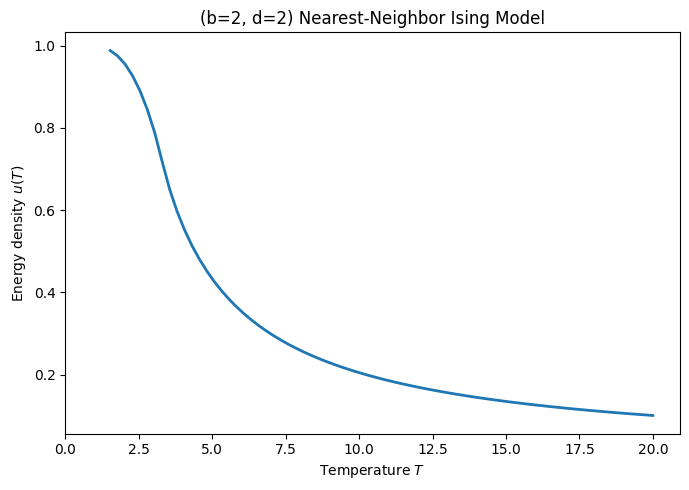

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Temperature range
T_values = np.linspace(0.01, 20.0, 80)

# RG / numerical parameters
max_steps = 10
dJ_rel = 1e-6       # relative increment for numerical derivative

u_values = []
for T in T_values:
    uT = energy_density_u(T, max_steps=max_steps, dJ_rel=dJ_rel)
    u_values.append(uT)
u_values = np.array(u_values)

plt.figure(figsize=(7, 5))
plt.plot(T_values, u_values, lw=2, markersize=4)
plt.xlim(0, None)
plt.xlabel("Temperature $T$")
plt.ylabel("Energy density $u(T)$")
plt.title("(b=2, d=2) Nearest-Neighbor Ising Model")
plt.tight_layout()
plt.show()

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

# ----------------------------
# Utility: logsumexp (numba)
# ----------------------------
@njit(cache=True)
def logsumexp(values):
    m = np.max(values)
    s = 0.0
    for v in values:
        s += np.exp(v - m)
    return m + np.log(s)


# Internal spin configurations to be decimated: s1 = ±1
_internal_spins = np.array([-1, 1], dtype=np.int64)


# ----------------------------
# MK b=2, d=2: compute log R by summing configs
# ----------------------------
@njit(cache=True)
def log_R_boundary_nn_mk_b2_d2(sL, sR, J):
    """
    Computes log R(sL, sR) for the MK-renormalized bond using an explicit
    sum over the decimated spin s1.

    Steps:
      - bond moving: J_bm = b^(d-1) * J = 2J   (since b=2, d=2)
      - decimation on a 3-spin chain: sL - s1 - sR with couplings J_bm on both bonds

    R(sL,sR) = sum_{s1=±1} exp[ J_bm*(sL*s1 + s1*sR) ].
    """
    J_bm = 2.0 * J

    totals = np.empty(_internal_spins.shape[0], dtype=np.float64)
    for i in range(_internal_spins.shape[0]):
        s1 = _internal_spins[i]
        E = J_bm * (sL * s1 + s1 * sR)  # dimensionless exponent contribution
        totals[i] = E

    return logsumexp(totals)


@njit(cache=True)
def log_Rpp_Rpm_nn_mk_b2_d2_numeric(J):
    """
    Returns (log R(++), log R(+-)) computed numerically from configuration sums.
    Uses boundary spins (sL,sR) = (+1,+1) and (+1,-1).
    """
    log_R_pp = log_R_boundary_nn_mk_b2_d2(1,  1, J)
    log_R_pm = log_R_boundary_nn_mk_b2_d2(1, -1, J)
    return log_R_pp, log_R_pm


@njit(cache=True)
def rg_step_J_nn_mk_b2_d2_numeric(J):
    """
    One MK RG step:
      J' = 0.5*(log R(++) - log R(+-))
    """
    log_R_pp, log_R_pm = log_Rpp_Rpm_nn_mk_b2_d2_numeric(J)
    return 0.5 * (log_R_pp - log_R_pm)


@njit(cache=True)
def G_tilde_nn_mk_b2_d2_numeric(J):
    """
    Additive constant:
      G~ = 0.5*(log R(++) + log R(+-))
    """
    log_R_pp, log_R_pm = log_Rpp_Rpm_nn_mk_b2_d2_numeric(J)
    return 0.5 * (log_R_pp + log_R_pm)


def free_energy_from_G_numeric(J0, max_steps=25):
    """
    Free energy density reconstructed from additive constants under MK.

    f(J) ≈ Σ_{k=0}^{max_steps-1} b^{-d(k+1)} * G~(J_k),
    with b=2, d=2 => weight = 2^{-2(k+1)} = 4^{-(k+1)}.
    """
    J = float(J0)
    f = 0.0
    for k in range(max_steps):
        Gk = float(G_tilde_nn_mk_b2_d2_numeric(J))
        f += (2.0 ** (-2 * (k + 1))) * Gk
        J = float(rg_step_J_nn_mk_b2_d2_numeric(J))
    return f


def energy_density_u_numeric(T, max_steps=25, dJ_rel=1e-6):
    """
    Energy density u(T) = df/dJ, with J = 1/T.
    Computed numerically via finite difference, same logic as your long-range u_r.
    """
    J = 1.0 / T
    dJ = dJ_rel * max(abs(J), 1e-10)

    f0 = free_energy_from_G_numeric(J, max_steps=max_steps)
    f1 = free_energy_from_G_numeric(J + dJ, max_steps=max_steps)
    return (f1 - f0) / dJ


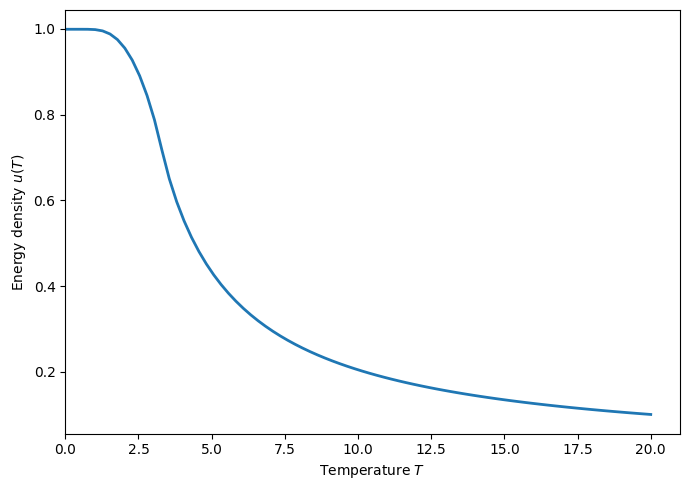

In [41]:
# Temperature range
T_values = np.linspace(0.01, 20.0, 80)

# Parameters
max_steps = 10
dJ_rel = 1e-6

u_values = np.array([energy_density_u_numeric(T, max_steps=max_steps, dJ_rel=dJ_rel) for T in T_values], dtype=float)

plt.figure(figsize=(7, 5))
plt.plot(T_values, u_values, lw=2)
plt.xlim(0, None)
plt.xlabel("Temperature $T$")
plt.ylabel("Energy density $u(T)$")
#plt.title("(b=2, d=2) NN Ising: $u(T)$ from summed $\\tilde G$ (numeric $R$)")
plt.tight_layout()
plt.show()